In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


# 1 - Data Preprocessing
* Data from 2012 until 2016 (only working days, about 20 days per month)
* Predict the whole month of January 2017
* We can't predict the real price, but only the trends (+/-/0)
* keras takes only numpy arrays composed only of values
* ARIMA yields better results in forecasting short term, whereas LSTM yields better results for long term modeling

In [3]:
# Importing the training set
dataset_train = pd.read_csv('./Data/Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:, 1:2].values

In [8]:
dataset_train.shape

(1258, 6)

In [6]:
dataset_train.head(3)

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"


In [7]:
dataset_train.tail(3)

,Date,Open,High,Low,Close,Volume
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"
1257,12/30/2016,782.75,782.78,770.41,771.82,"1,770,000"


In [13]:
training_set[:3]

array([[325.25],
       [331.27],
       [329.83]])

In [10]:
len(training_set)

1258

* Standarization, substract mean and divide by standard deviation
* Normalization, substract min and divide by range max-min
* RNN is recommended to utilize normalization
* if there is a sigmoid function as the activation function in the output layer of you RNN, apply normalization.

In [14]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [15]:
training_set_scaled[:3]

array([[0.08581368],
       [0.09701243],
       [0.09433366]])

* Number of time steps: create a data structure specifying what the RNN will need to remember when predicting the next stock price.
* This number can lead to overfitting or underfitting
* timesteps = 60, at each time T, the RNN is going to look at the 60 stock prices before time T, and predict
* timesteps = 1 leads to overfitting
* timesteps = 20,30,40 not good enough to capture trends
* 20 days per month (workday), then 60 is 3 month of previous info

In [30]:
len(training_set_scaled)

1258

In [31]:
# Creating a data structure starting from 60
X_train = []
y_train = []
timesteps = 60
for i in range(timesteps, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-timesteps:i, 0])
    y_train.append(training_set_scaled[i, 0])
print(0,i-timesteps)
print(timesteps,i)
X_train, y_train = np.array(X_train), np.array(y_train)

0 1197
60 1257


In [33]:
# all previous column in the X_train predict the row value in y_train
print(X_train.shape)
print(y_train.shape)

(1198, 60)
(1198,)


* This new dimension correspond if we want to add more information correlated to the final price.
* Example to give an idea, the Samsung and Apple price must be correlated
* This deliver a cube of information, but in this case the cube is of size = 1

In [34]:
# Reshaping, (x,y,1)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [37]:
print(X_train.shape)

(1198, 60, 1)


# 2 - Building the RNN
* Stack LSTM with dropout
* Add regularization to prevent overfit
* NN represented as a sequence of layers
* Regression is for continue values
* Classification is for defined classes
* return_sequences = True, because it is a stacked LSTM with several layers. When no more layers are being added the value is False (default)
* input_shape, the first one corresponding to the observations will be automatically taken into account.
* LSTM cells or memory units is 50 (low number gives low performance)
* Dropout rate or unit memories that are going to be dropped 20% (standar)

In [35]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

* Epochs-I, how many iterations do you want your RNN to be trained. 
* Epochs-II, how many times do you want the whole data, the whole training data to be forward propagated inside the neural network.
* 25,50, and 75 epochs does not converge
* So the RNN is going to be trained on batches rather than single observations.
* Instead of updating the weights every stock price, we are going to generate the error (that is back propagated into the neural network) every 32 stock prices.

In [36]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0405
Epoch 2/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0066
Epoch 3/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0052
Epoch 4/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0048
Epoch 5/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0044
Epoch 6/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0043
Epoch 7/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0050
Epoch 8/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0057
Epoch 9/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0046
Epoch 10/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0045
Epoch 11/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0048
Epoch 12/100
1198/1198 [==============================] - 4s 3ms/step - lo

1198/1198 [==============================] - 4s 3ms/step - loss: 0.0016
Epoch 98/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0015
Epoch 99/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0014
Epoch 100/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0015


# 3 - Making the predictions and visualising the results

In [39]:
# Getting the real stock price of 2017
dataset_test = pd.read_csv('./Data/Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [41]:
real_stock_price

array([[778.81],
       [788.36],
       [786.08],
       [795.26],
       [806.4 ],
       [807.86],
       [805.  ],
       [807.14],
       [807.48],
       [807.08],
       [805.81],
       [805.12],
       [806.91],
       [807.25],
       [822.3 ],
       [829.62],
       [837.81],
       [834.71],
       [814.66],
       [796.86]])

In [40]:
real_stock_price.shape

(20, 1)

Getting the predicted stock price of 2017

In [42]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
dataset_total

0     325.25
1     331.27
2     329.83
3     328.34
4     322.04
       ...  
15    829.62
16    837.81
17    834.71
18    814.66
19    796.86
Name: Open, Length: 1278, dtype: float64

In [46]:
# 80 values = 20 test + 60 previous(real values)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs

array([779.  , 779.66, 777.71, 786.66, 783.76, 781.22, 781.65, 779.8 ,
       787.85, 798.24, 803.3 , 795.  , 804.9 , 816.68, 806.34, 801.  ,
       808.35, 795.47, 782.89, 778.2 , 767.25, 750.66, 774.5 , 783.4 ,
       779.94, 791.17, 756.54, 755.6 , 746.97, 755.2 , 766.92, 771.37,
       762.61, 772.63, 767.73, 764.26, 760.  , 771.53, 770.07, 757.44,
       744.59, 757.71, 764.73, 761.  , 772.48, 780.  , 785.04, 793.9 ,
       797.4 , 797.34, 800.4 , 790.22, 796.76, 795.84, 792.36, 790.9 ,
       790.68, 793.7 , 783.33, 782.75, 778.81, 788.36, 786.08, 795.26,
       806.4 , 807.86, 805.  , 807.14, 807.48, 807.08, 805.81, 805.12,
       806.91, 807.25, 822.3 , 829.62, 837.81, 834.71, 814.66, 796.86])

In [58]:
real_stock_price

array([[778.81],
       [788.36],
       [786.08],
       [795.26],
       [806.4 ],
       [807.86],
       [805.  ],
       [807.14],
       [807.48],
       [807.08],
       [805.81],
       [805.12],
       [806.91],
       [807.25],
       [822.3 ],
       [829.62],
       [837.81],
       [834.71],
       [814.66],
       [796.86]])

In [47]:
inputs = inputs.reshape(-1,1)
inputs

array([[779.  ],
       [779.66],
       [777.71],
       [786.66],
       [783.76],
       [781.22],
       [781.65],
       [779.8 ],
       [787.85],
       [798.24],
       [803.3 ],
       [795.  ],
       [804.9 ],
       [816.68],
       [806.34],
       [801.  ],
       [808.35],
       [795.47],
       [782.89],
       [778.2 ],
       [767.25],
       [750.66],
       [774.5 ],
       [783.4 ],
       [779.94],
       [791.17],
       [756.54],
       [755.6 ],
       [746.97],
       [755.2 ],
       [766.92],
       [771.37],
       [762.61],
       [772.63],
       [767.73],
       [764.26],
       [760.  ],
       [771.53],
       [770.07],
       [757.44],
       [744.59],
       [757.71],
       [764.73],
       [761.  ],
       [772.48],
       [780.  ],
       [785.04],
       [793.9 ],
       [797.4 ],
       [797.34],
       [800.4 ],
       [790.22],
       [796.76],
       [795.84],
       [792.36],
       [790.9 ],
       [790.68],
       [793.7 ],
       [783.33

In [48]:
inputs = sc.transform(inputs)
inputs

array([[0.9299055 ],
       [0.93113327],
       [0.92750577],
       [0.94415507],
       [0.93876032],
       [0.93403527],
       [0.93483518],
       [0.9313937 ],
       [0.94636878],
       [0.96569685],
       [0.97510976],
       [0.95966962],
       [0.97808617],
       [1.        ],
       [0.98076494],
       [0.97083116],
       [0.98450406],
       [0.96054394],
       [0.9371419 ],
       [0.92841729],
       [0.90804747],
       [0.8771858 ],
       [0.92153434],
       [0.93809063],
       [0.93165414],
       [0.95254483],
       [0.88812412],
       [0.88637547],
       [0.87032145],
       [0.88563137],
       [0.90743359],
       [0.91571173],
       [0.89941588],
       [0.91805566],
       [0.9089404 ],
       [0.9024853 ],
       [0.89456061],
       [0.91600938],
       [0.9132934 ],
       [0.88979835],
       [0.86589404],
       [0.89030062],
       [0.90335962],
       [0.89642086],
       [0.91777662],
       [0.93176576],
       [0.94114145],
       [0.957

In [55]:
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(20, 60, 1)


In [56]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [57]:
predicted_stock_price

array([[781.58685],
       [778.9257 ],
       [778.4643 ],
       [779.321  ],
       [782.1746 ],
       [787.52814],
       [793.0421 ],
       [796.14197],
       [797.21045],
       [797.16925],
       [796.7586 ],
       [796.2709 ],
       [795.9213 ],
       [796.2417 ],
       [797.076  ],
       [800.9415 ],
       [807.2037 ],
       [814.47144],
       [819.3481 ],
       [817.2916 ]], dtype=float32)

# 4.  Visualising the results

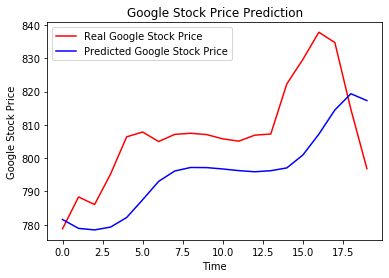

In [59]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()